# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import matplotlib as mpl

# Set publication-quality style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'STIXGeneral']
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 300

In [4]:
# Load the data
df = pd.read_csv('../data/preprocessed/walmart/walmart.csv')  # If you have it as a file
# Or use: df = pd.read_clipboard() if you've copied it to clipboard

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Filter data for stores 1 and 3
stores_to_plot = [1, 3]
filtered_df = df[df['Store'].isin(stores_to_plot)]

filtered_df.sample(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
400,3,2012-04-13,420789.74,0,72.83,3.891,225.013556,6.664
423,3,2012-09-21,414392.09,0,72.78,3.721,226.315150,6.334
357,3,2011-06-17,403423.34,0,86.96,3.637,218.355175,7.574
66,1,2011-05-13,1604775.58,0,75.64,3.899,215.964053,7.682
38,1,2010-10-29,1384209.22,0,69.64,2.716,211.908844,7.838
71,1,2011-06-17,1532114.86,0,86.41,3.637,214.998060,7.682
67,1,2011-05-20,1428218.27,0,67.63,3.907,215.733920,7.682
101,1,2012-01-13,1459601.17,0,48.53,3.261,219.892526,7.348
380,3,2011-11-25,556925.19,1,68.00,3.236,221.901118,7.197
301,3,2010-05-21,343763.17,0,75.81,2.826,213.911689,7.343


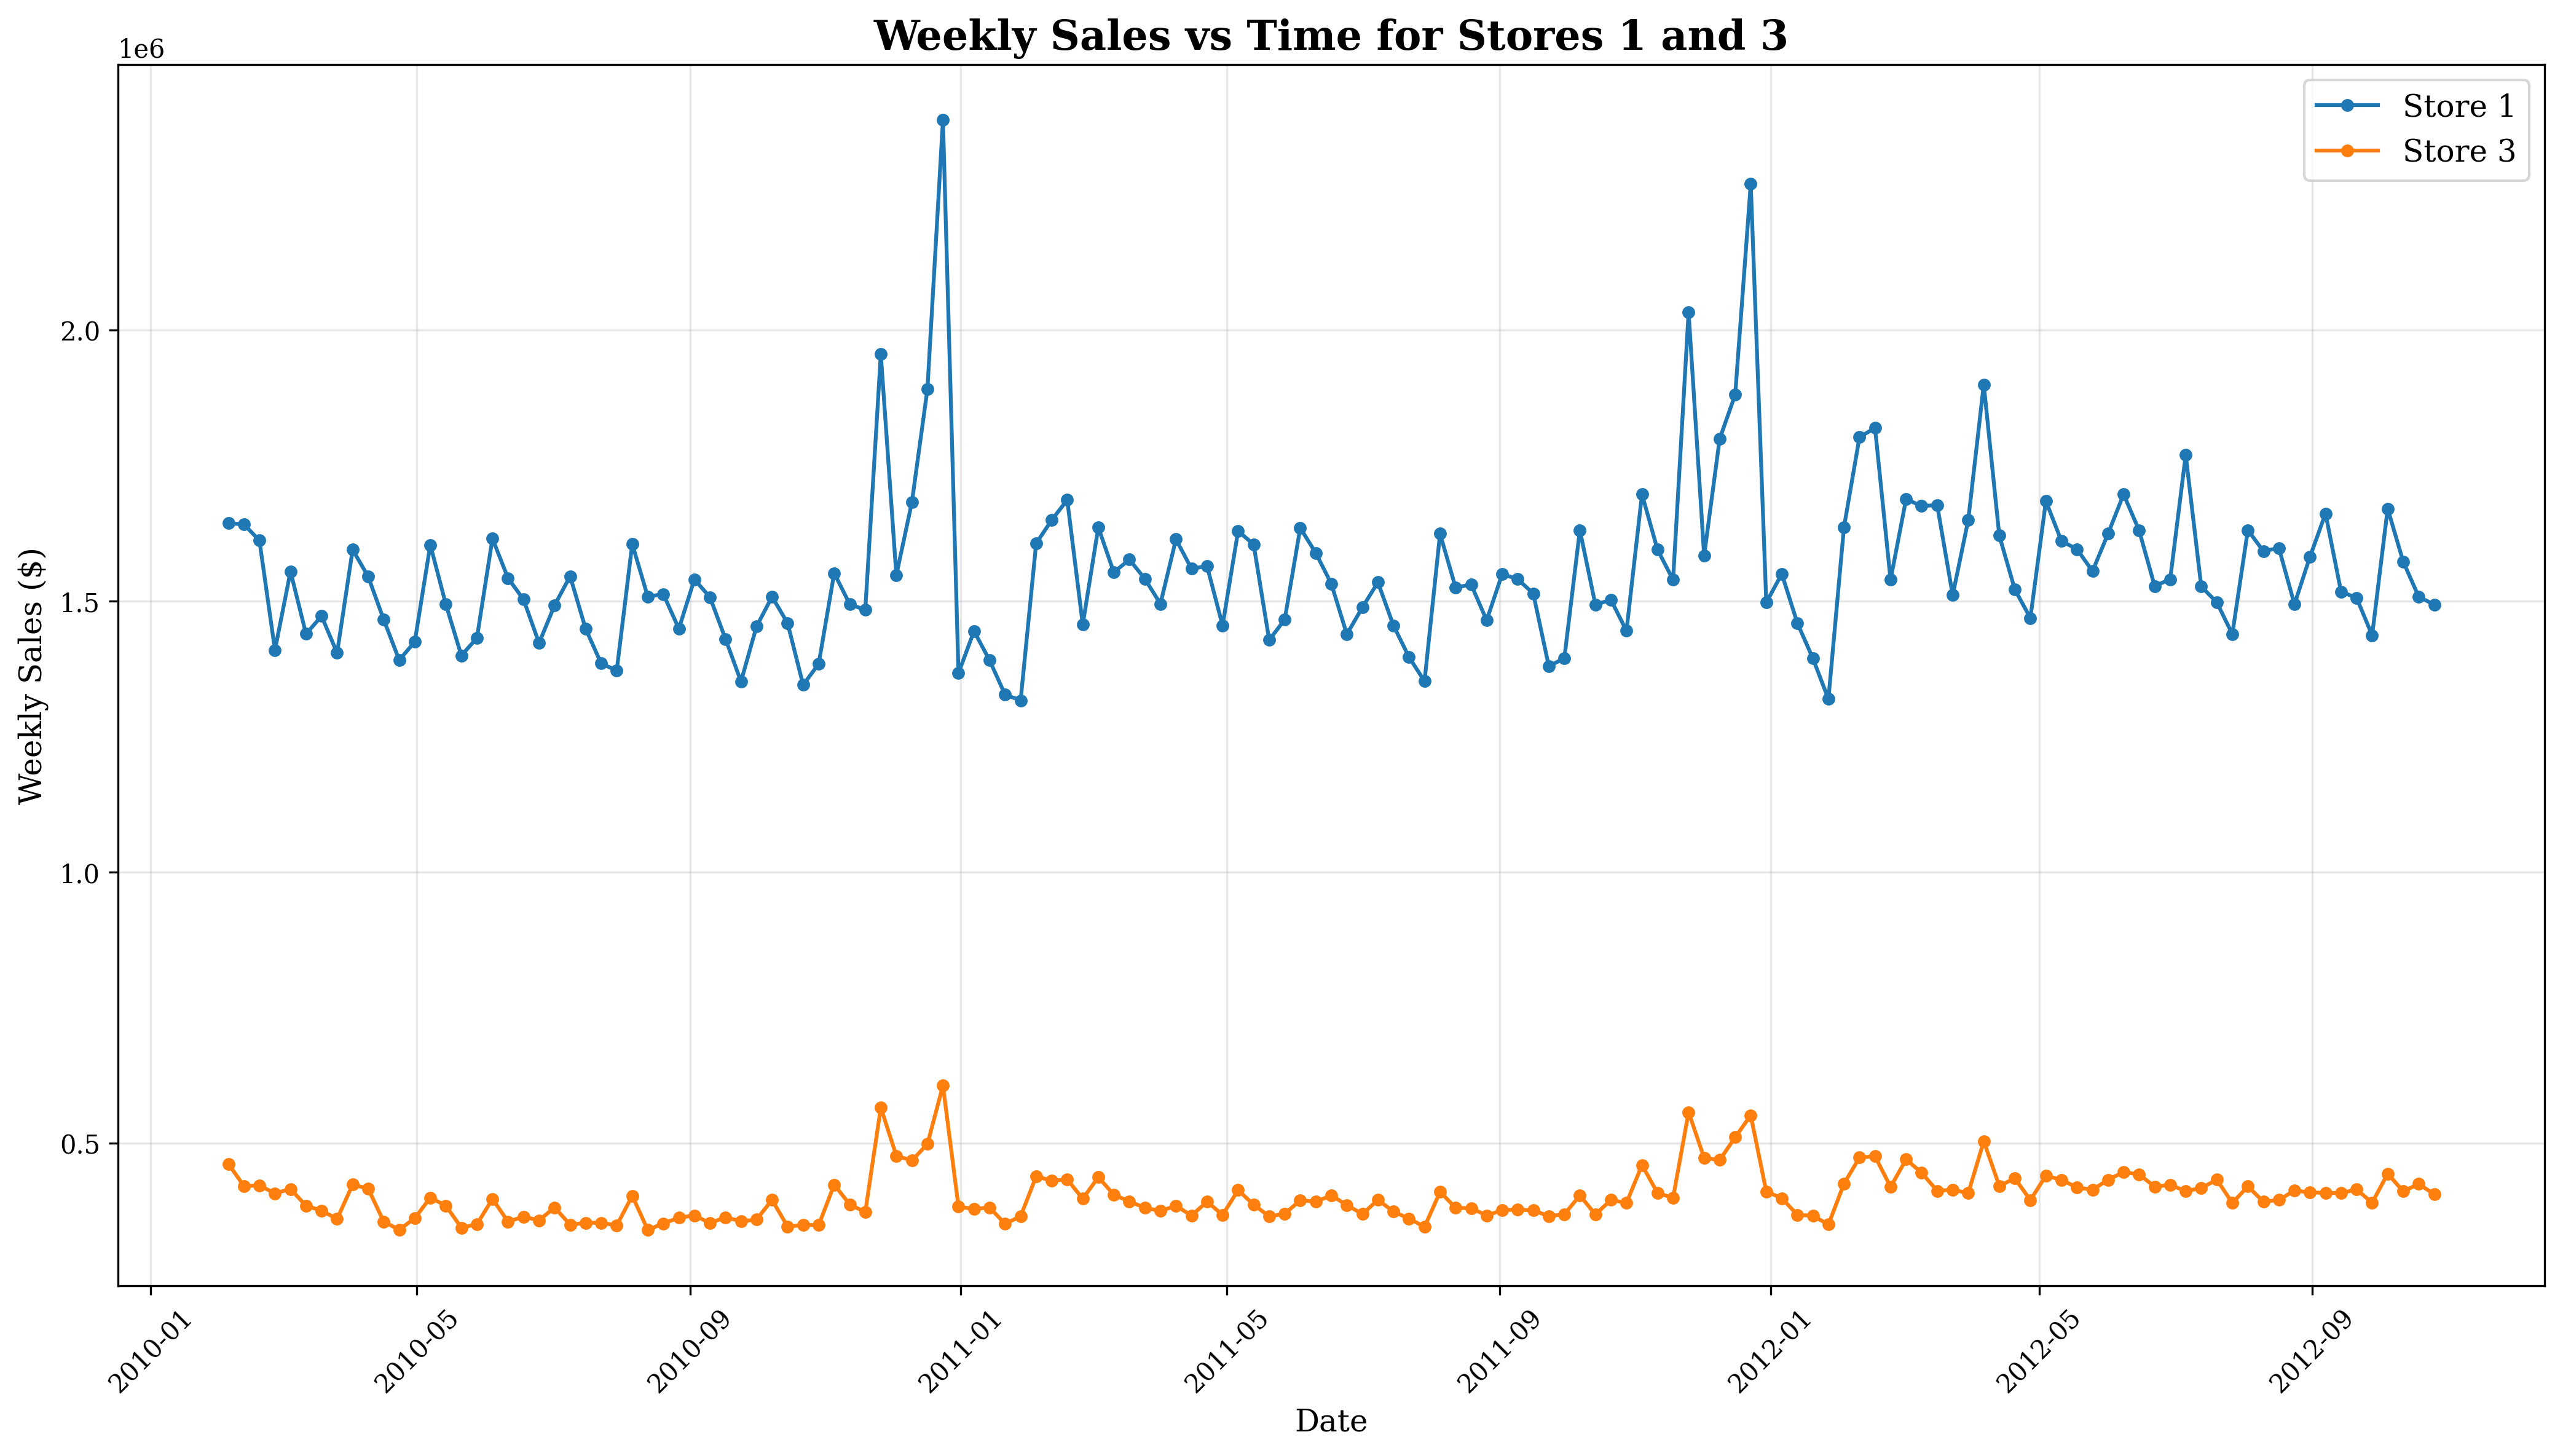

In [5]:
# Create a separate plot for each store
plt.figure(figsize=(14, 8))

for store in stores_to_plot:
    store_data = filtered_df[filtered_df['Store'] == store].sort_values('Date')
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], 
             marker='o', markersize=4, linewidth=1.5, label=f'Store {store}')

# Customize the plot
plt.title('Weekly Sales vs Time for Stores 1 and 3', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../figures/walmart_forecast_plots/sales_vs_time_1_3.png', dpi=300, bbox_inches='tight')

plt.show()

In [6]:
print(f"Date range for Store 1: {filtered_df[filtered_df['Store']==1]['Date'].min()} to {filtered_df[filtered_df['Store']==1]['Date'].max()}")
print(f"Date range for Store 3: {filtered_df[filtered_df['Store']==3]['Date'].min()} to {filtered_df[filtered_df['Store']==3]['Date'].max()}")
print(f"Number of weeks for Store 1: {len(filtered_df[filtered_df['Store']==1])}")
print(f"Number of weeks for Store 3: {len(filtered_df[filtered_df['Store']==3])}")

Date range for Store 1: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Date range for Store 3: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of weeks for Store 1: 143
Number of weeks for Store 3: 143



Decomposing Store 1...


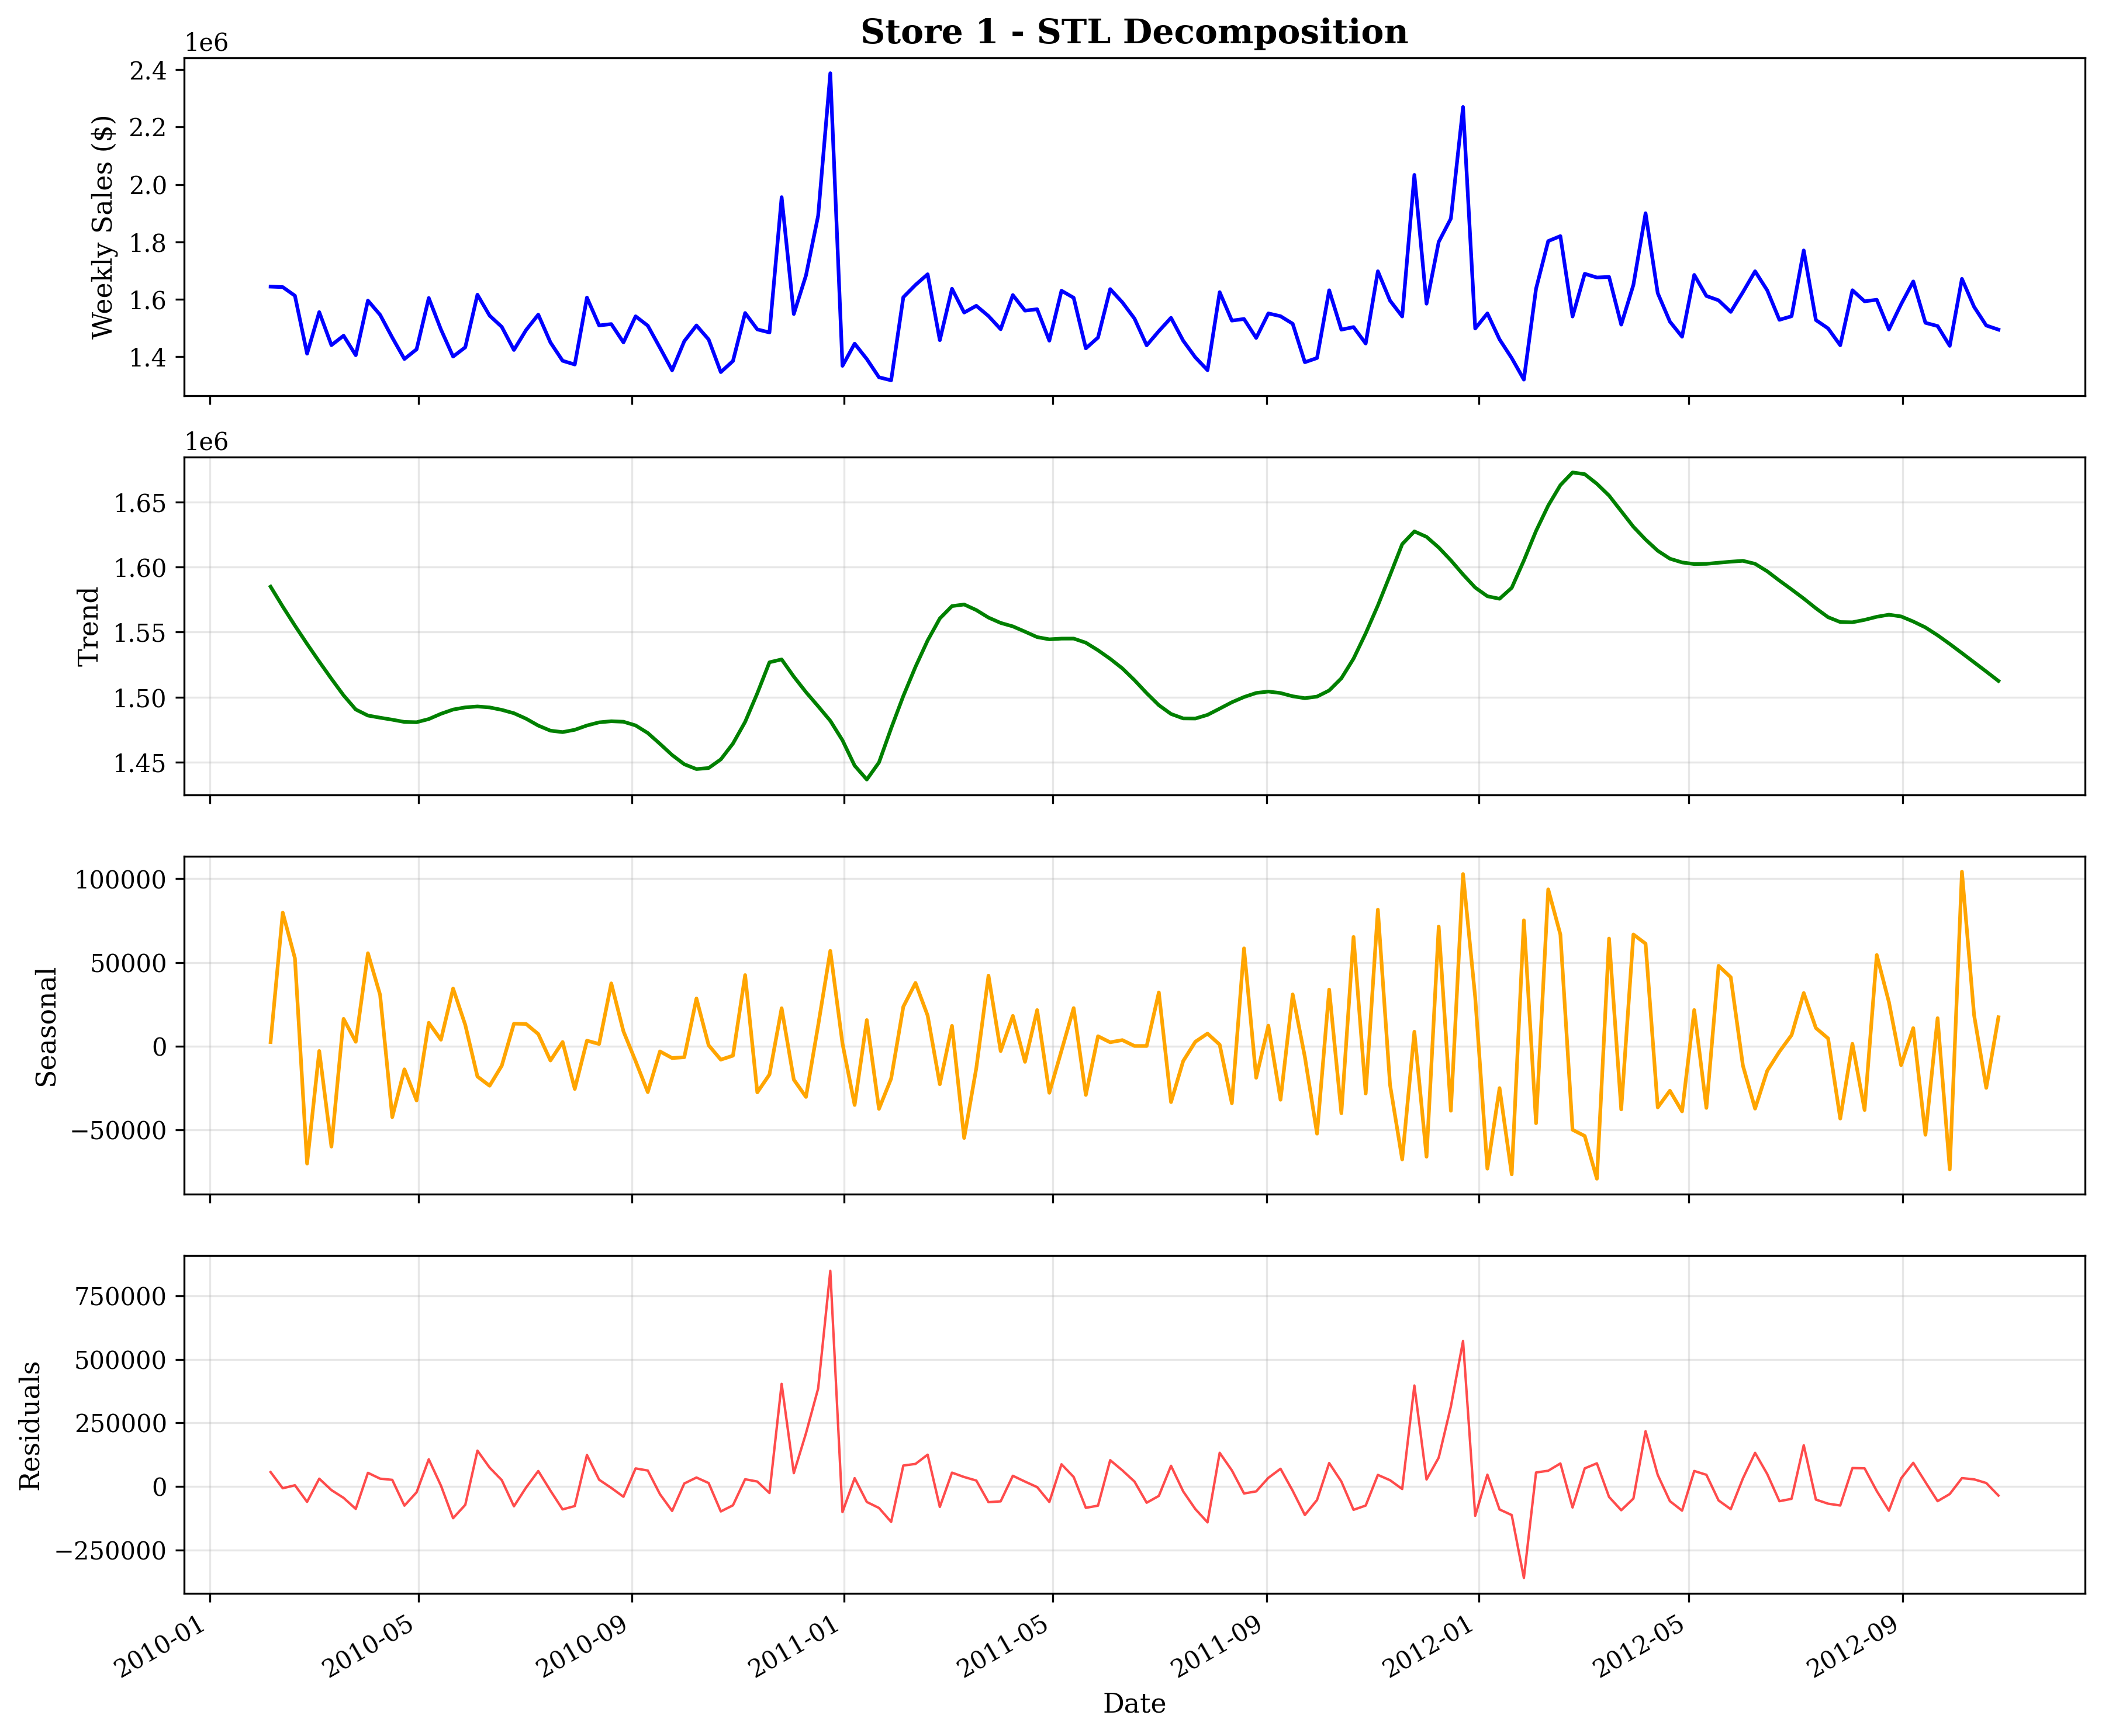


Decomposing Store 3...


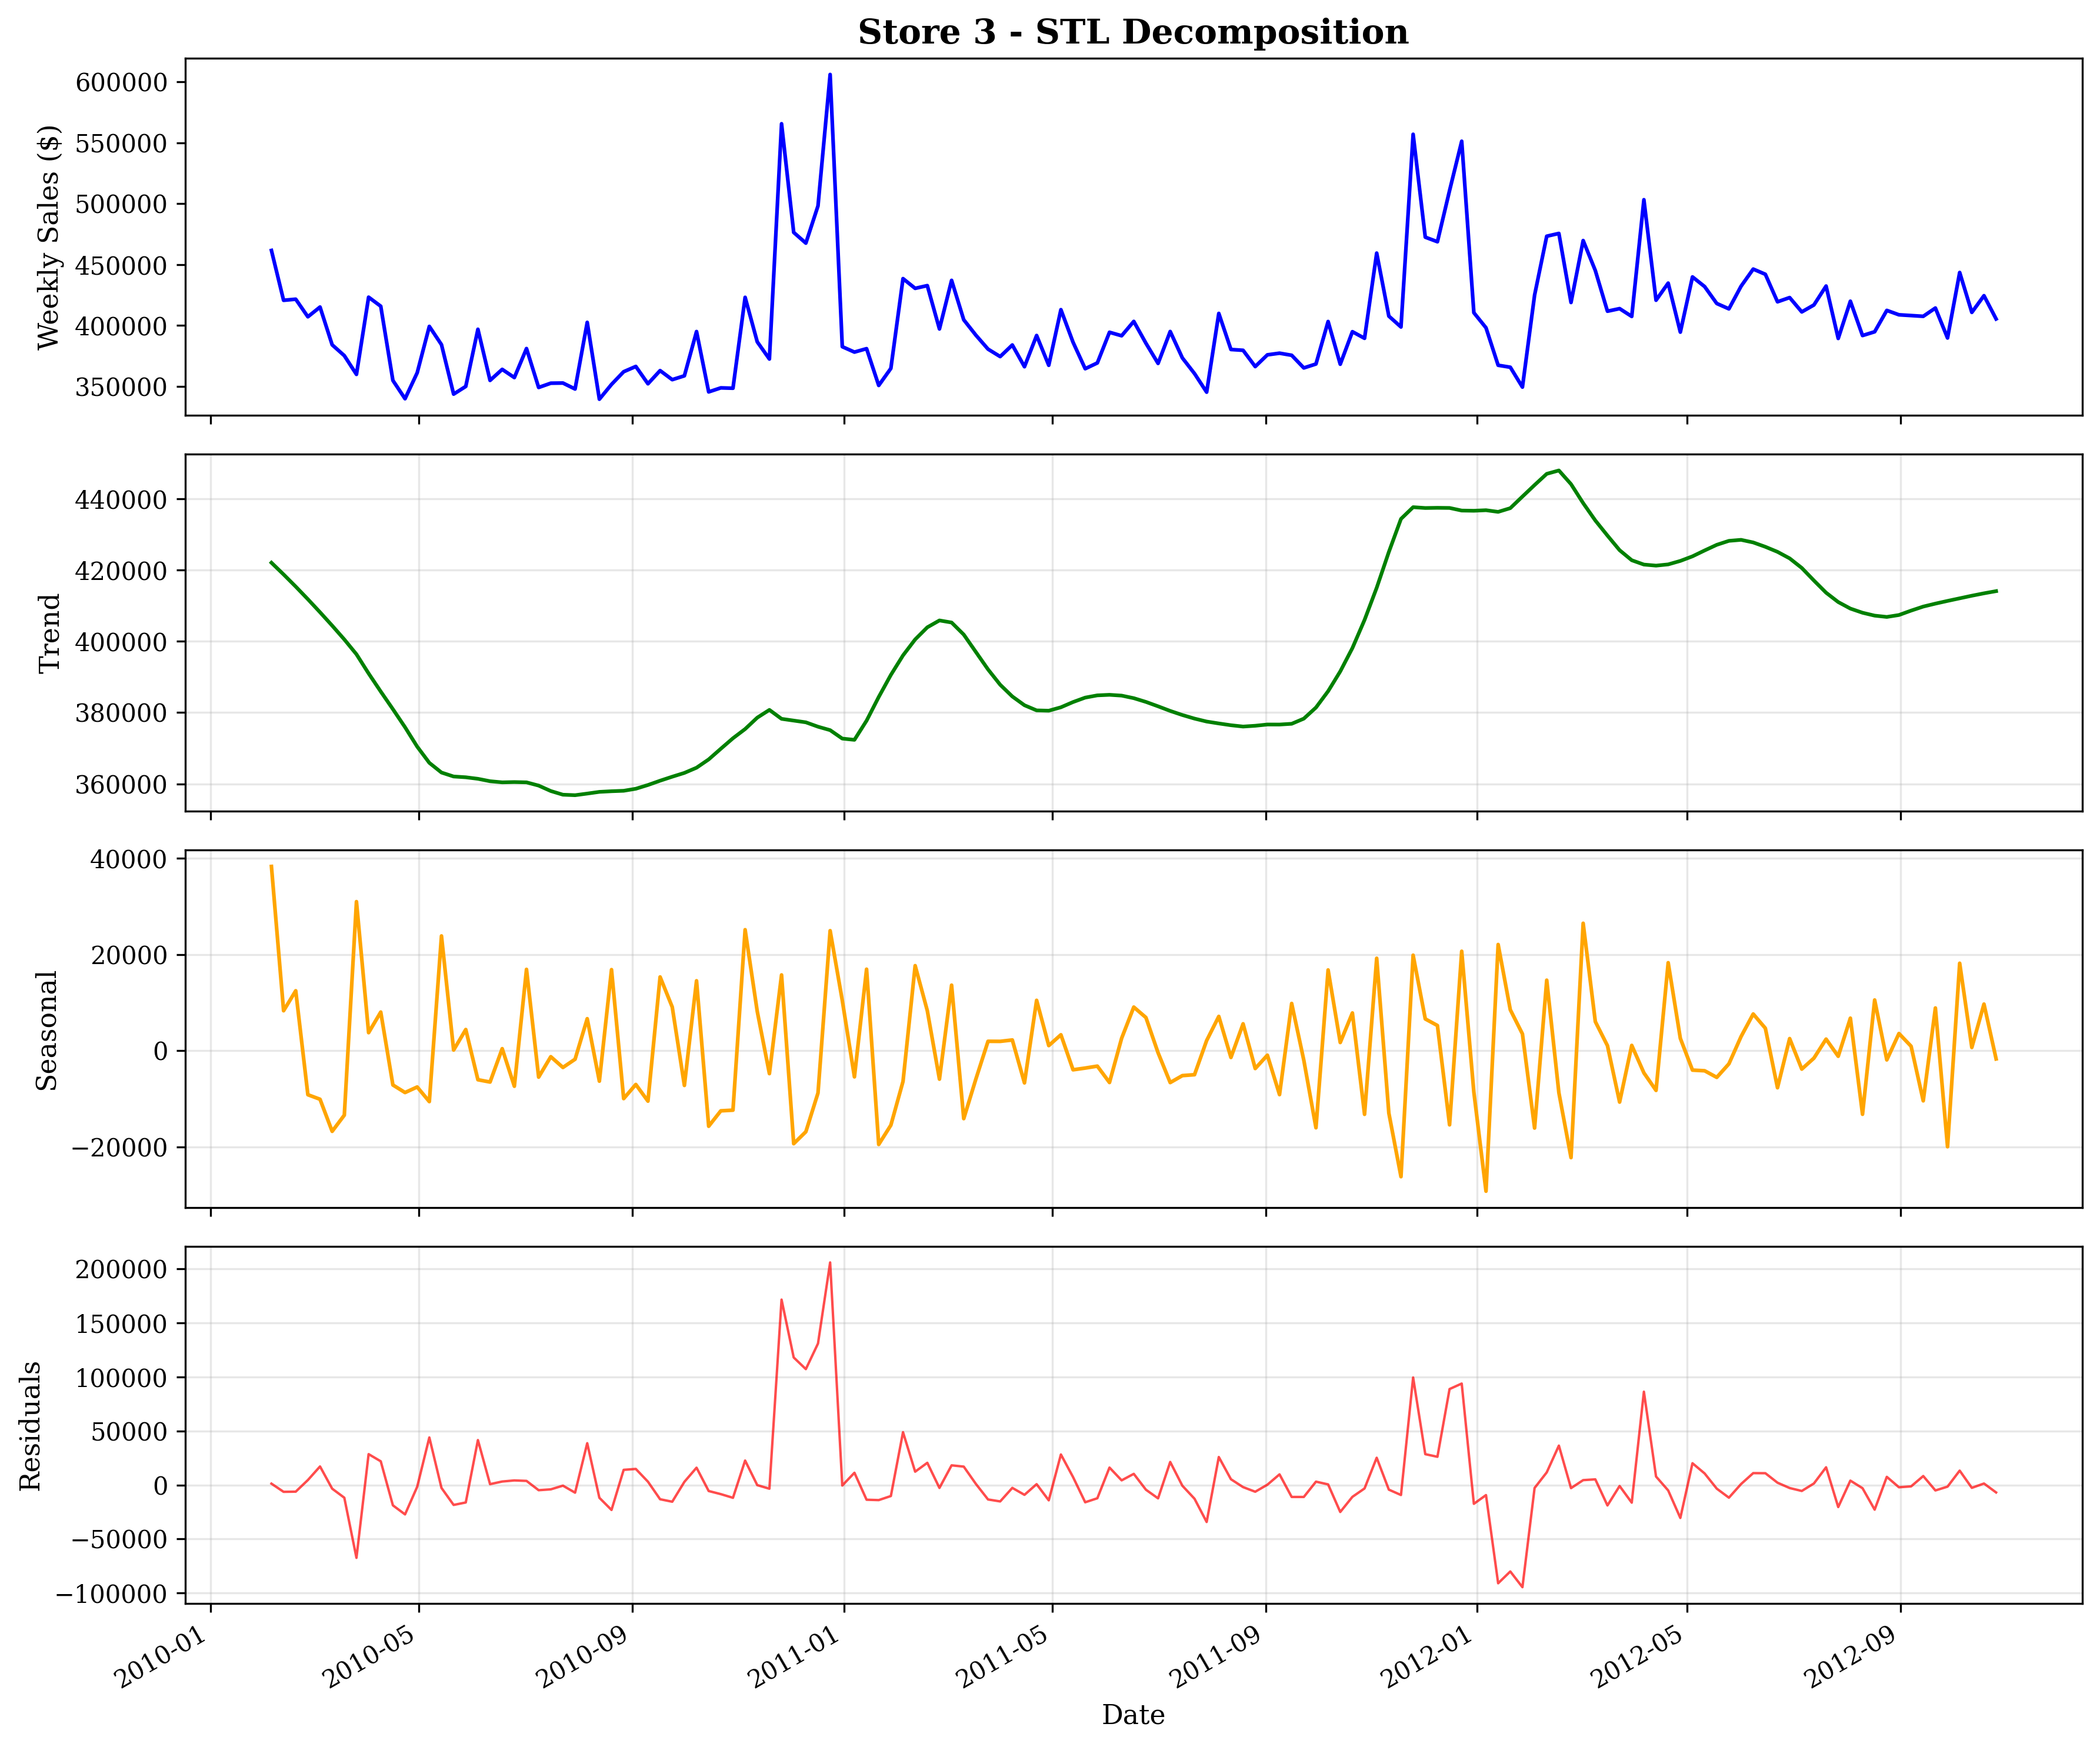


DECOMPOSITION SUMMARY

Store 1:
  Original Data: $1,555,264.40 mean, $155,980.77 std
  Trend: $1,535,770.96 mean
  Seasonal: Amplitude of $38,207.57
  Residuals: $18,897.41 mean, $130,965.35 std
  Seasonal Strength: 19.51%
  Trend Strength: 14.84%

Store 3:
  Original Data: $402,704.44 mean, $46,319.63 std
  Trend: $396,199.49 mean
  Seasonal: Amplitude of $11,899.93
  Residuals: $6,174.81 mean, $37,650.62 std
  Seasonal Strength: 28.15%
  Trend Strength: 10.03%


In [8]:
# Function to perform STL decomposition for a single store
def decompose_store_sales(store_id, period=52, figsize=(12, 10)):
    """Perform STL decomposition for a specific store."""
    # Get store data
    store_df = filtered_df[filtered_df['Store'] == store_id]
    
    # Set date as index
    store_series = store_df.set_index('Date')['Weekly_Sales']
    
    # Check if we have enough data points
    if len(store_series) < 2 * period:
        print(f"Warning: Store {store_id} has only {len(store_series)} data points, which is less than 2 * period ({2*period}). Consider reducing the period.")
    
    # Perform STL decomposition (weekly data with yearly seasonality - period=52)
    try:
        decomposition = STL(store_series, period=period, robust=True).fit()
    except Exception as e:
        print(f"Error decomposing Store {store_id}: {e}")
        # Try with smaller period if 52 fails
        period = min(period, len(store_series) // 2)
        print(f"Trying with period={period}")
        decomposition = STL(store_series, period=period, robust=True).fit()
    
    # Create plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=figsize)
    
    ax1.plot(decomposition.observed, color='blue', linewidth=1.5)
    ax1.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax1.set_title(f'Store {store_id} - STL Decomposition', fontsize=14, fontweight='bold')
    
    ax2.plot(decomposition.trend, color='green', linewidth=1.5)
    ax2.set_ylabel('Trend', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(decomposition.seasonal, color='orange', linewidth=1.5)
    ax3.set_ylabel('Seasonal', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(decomposition.resid, color='red', linewidth=1, alpha=0.7)
    ax4.set_ylabel('Residuals', fontsize=11)
    ax4.set_xlabel('Date', fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.xticks(rotation=45)
    fig.autofmt_xdate()
    plt.tight_layout()
    
    return fig, decomposition

# Decompose Store 1
print("\nDecomposing Store 1...")
fig1, decomp1 = decompose_store_sales(1, period=7)
plt.savefig('../figures/walmart_forecast_plots/store1_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Decompose Store 3
print("\nDecomposing Store 3...")
fig2, decomp2 = decompose_store_sales(3, period=7)
plt.savefig('../figures/walmart_forecast_plots/store3_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print summary statistics for both decompositions
print("\n" + "="*60)
print("DECOMPOSITION SUMMARY")
print("="*60)

for store_id, decomp in [(1, decomp1), (3, decomp2)]:
    print(f"\nStore {store_id}:")
    print(f"  Original Data: ${decomp.observed.mean():,.2f} mean, ${decomp.observed.std():,.2f} std")
    print(f"  Trend: ${decomp.trend.mean():,.2f} mean")
    print(f"  Seasonal: Amplitude of ${decomp.seasonal.std():,.2f}")
    print(f"  Residuals: ${decomp.resid.mean():,.2f} mean, ${decomp.resid.std():,.2f} std")
    
    # Calculate strength of components
    seasonal_strength = max(0, 1 - decomp.resid.var() / (decomp.trend + decomp.resid).var())
    trend_strength = max(0, 1 - decomp.resid.var() / (decomp.seasonal + decomp.resid).var())
    
    print(f"  Seasonal Strength: {seasonal_strength:.2%}")
    print(f"  Trend Strength: {trend_strength:.2%}")